First, I need to import relevant packages.

In [50]:
import pandas as pd
import numpy as np

# Dimensionality reduction packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD

# Models 
from sklearn.ensemble import GradientBoostingRegressor
from rgf.sklearn import RGFRegressor

# Validation and splitting packages
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Graphing packages 
import seaborn as sb
sb.set(context="paper", font="monospace")
import matplotlib.pyplot as plt
%matplotlib inline

# anomaly detector
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
import h2o

# Neural Networks
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.
/Users/juliacreighton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Next, I'm importing the datasets

In [3]:
training = pd.read_csv('~/Downloads/train.csv')
test = pd.read_csv('~/Downloads/test (1).csv')

In [4]:
training.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_y = training['SalePrice']
train_x = training.drop(['SalePrice'],axis=1)

In [6]:
train_x.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [7]:
print ('There are {} records in the training set.'.format(train_x.shape[0]))
print ('There are {} features in the training set.'.format(train_x.drop(['Id'],axis=1).shape[1]))

There are 1460 records in the training set.
There are 79 features in the training set.


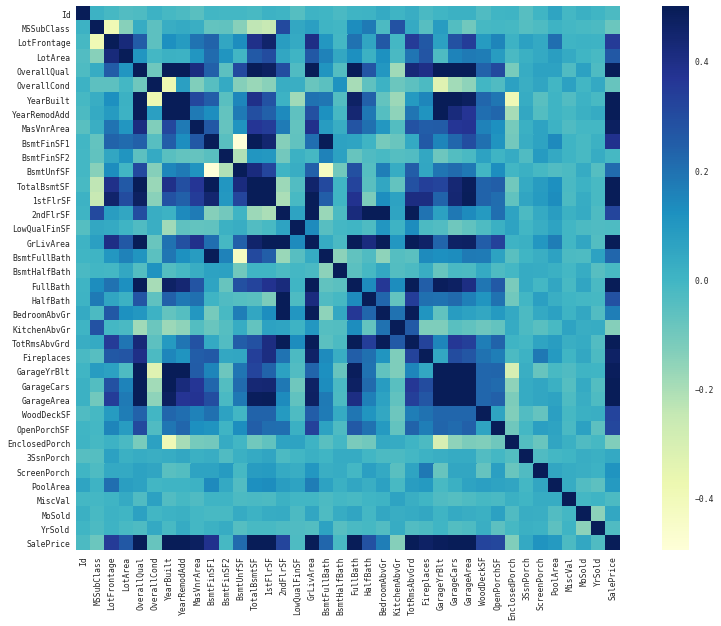

In [8]:
corrmat = training.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sb.heatmap(corrmat, vmax=0.5, square=True,center=0,cmap="YlGnBu")

Many of the variables are highly correlated with the target variable, and with each other. Luckily, the models I'm using handle that pretty well, but below I'll call out variables that are highly correlated (over 80%)

In [9]:
corr_matrix = train_x.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)

In [10]:
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [11]:
# These variables are highly correlated. Since I'm using a gradient boosting model, which 
# handles highly correlated variables well, it should be alright, but it's good to note.
high_corr_var

[('YearBuilt', 'GarageYrBlt'),
 ('TotalBsmtSF', '1stFlrSF'),
 ('GrLivArea', 'TotRmsAbvGrd'),
 ('GarageCars', 'GarageArea')]

Next, I want to visualize the distribution of the data. 

In [12]:
training.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
training.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [14]:
pd.set_option('display.max_columns', 500)
training.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


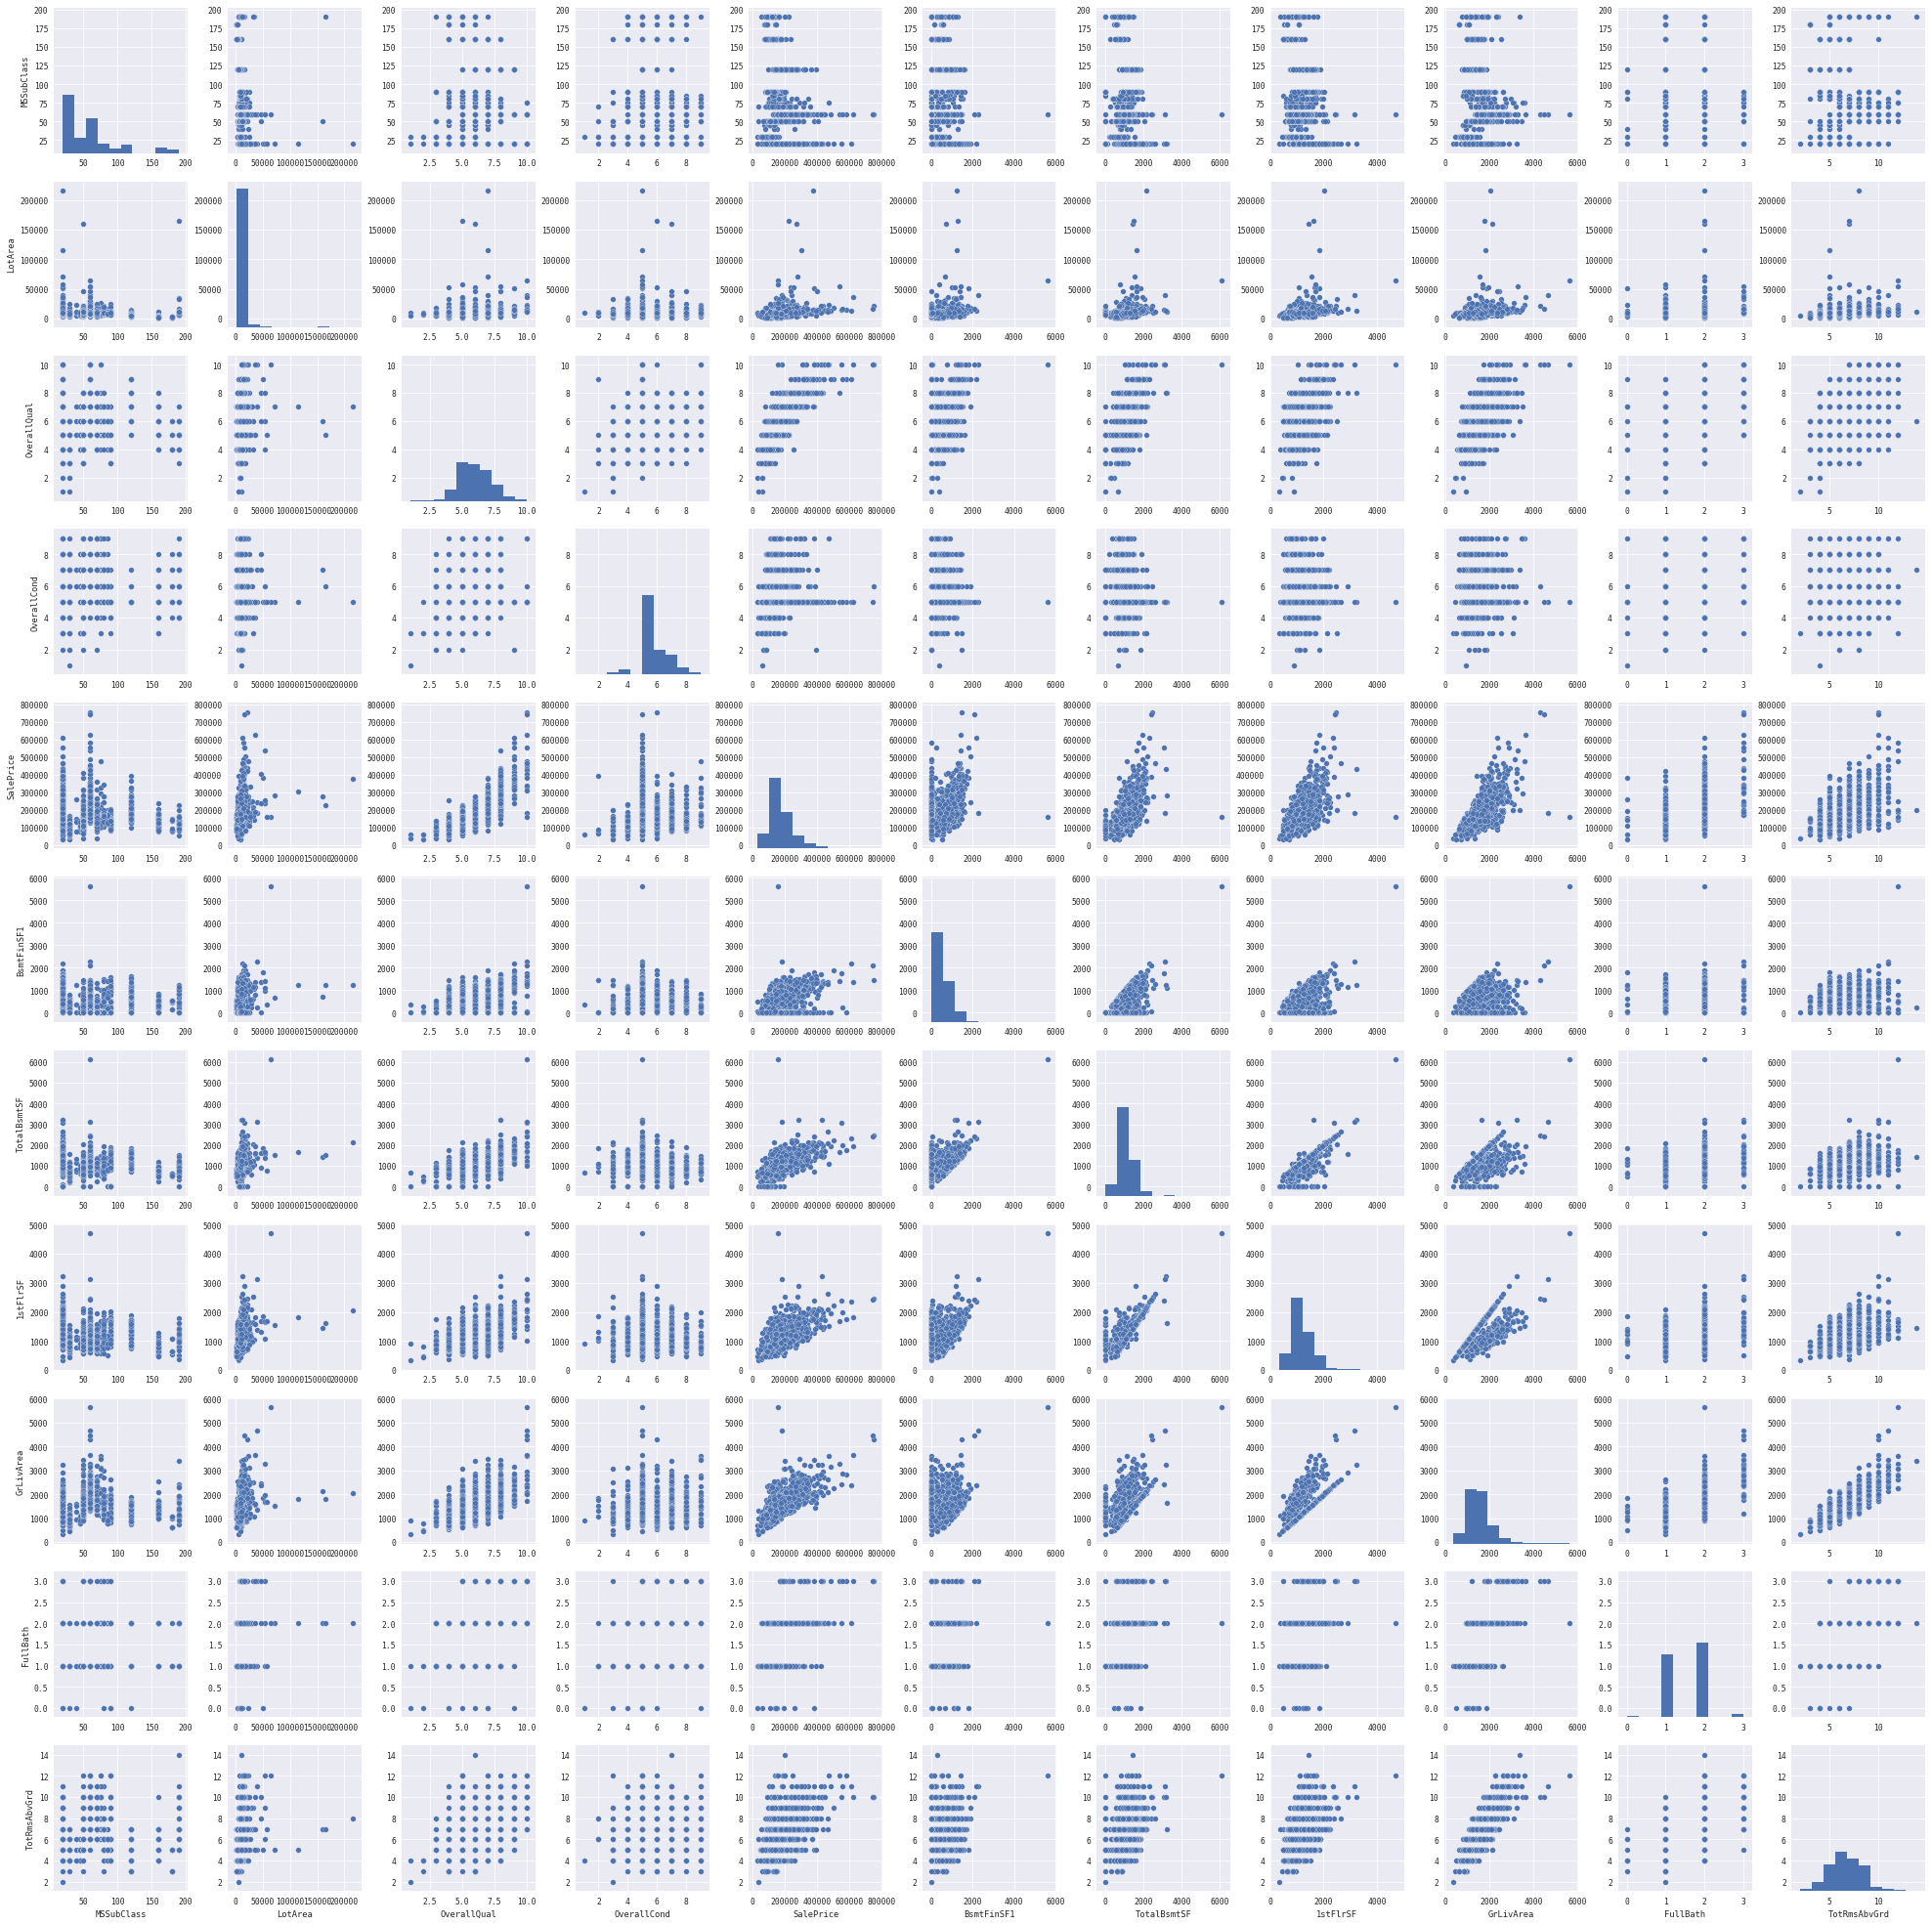

In [15]:
sb.pairplot(training[['MSSubClass','LotArea','OverallQual','OverallCond','SalePrice',\
                      'BsmtFinSF1','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd']])

In [16]:
# Lets try subsetting the training set to exclude the extreme outliers 
training_set = training[training.BsmtFinSF1 <4000]  # training.LotArea< 100000 &
training_set = training_set[training_set.LotArea< 100000] 


train_y = training['SalePrice']
train_x = training.drop(['SalePrice'],axis=1)

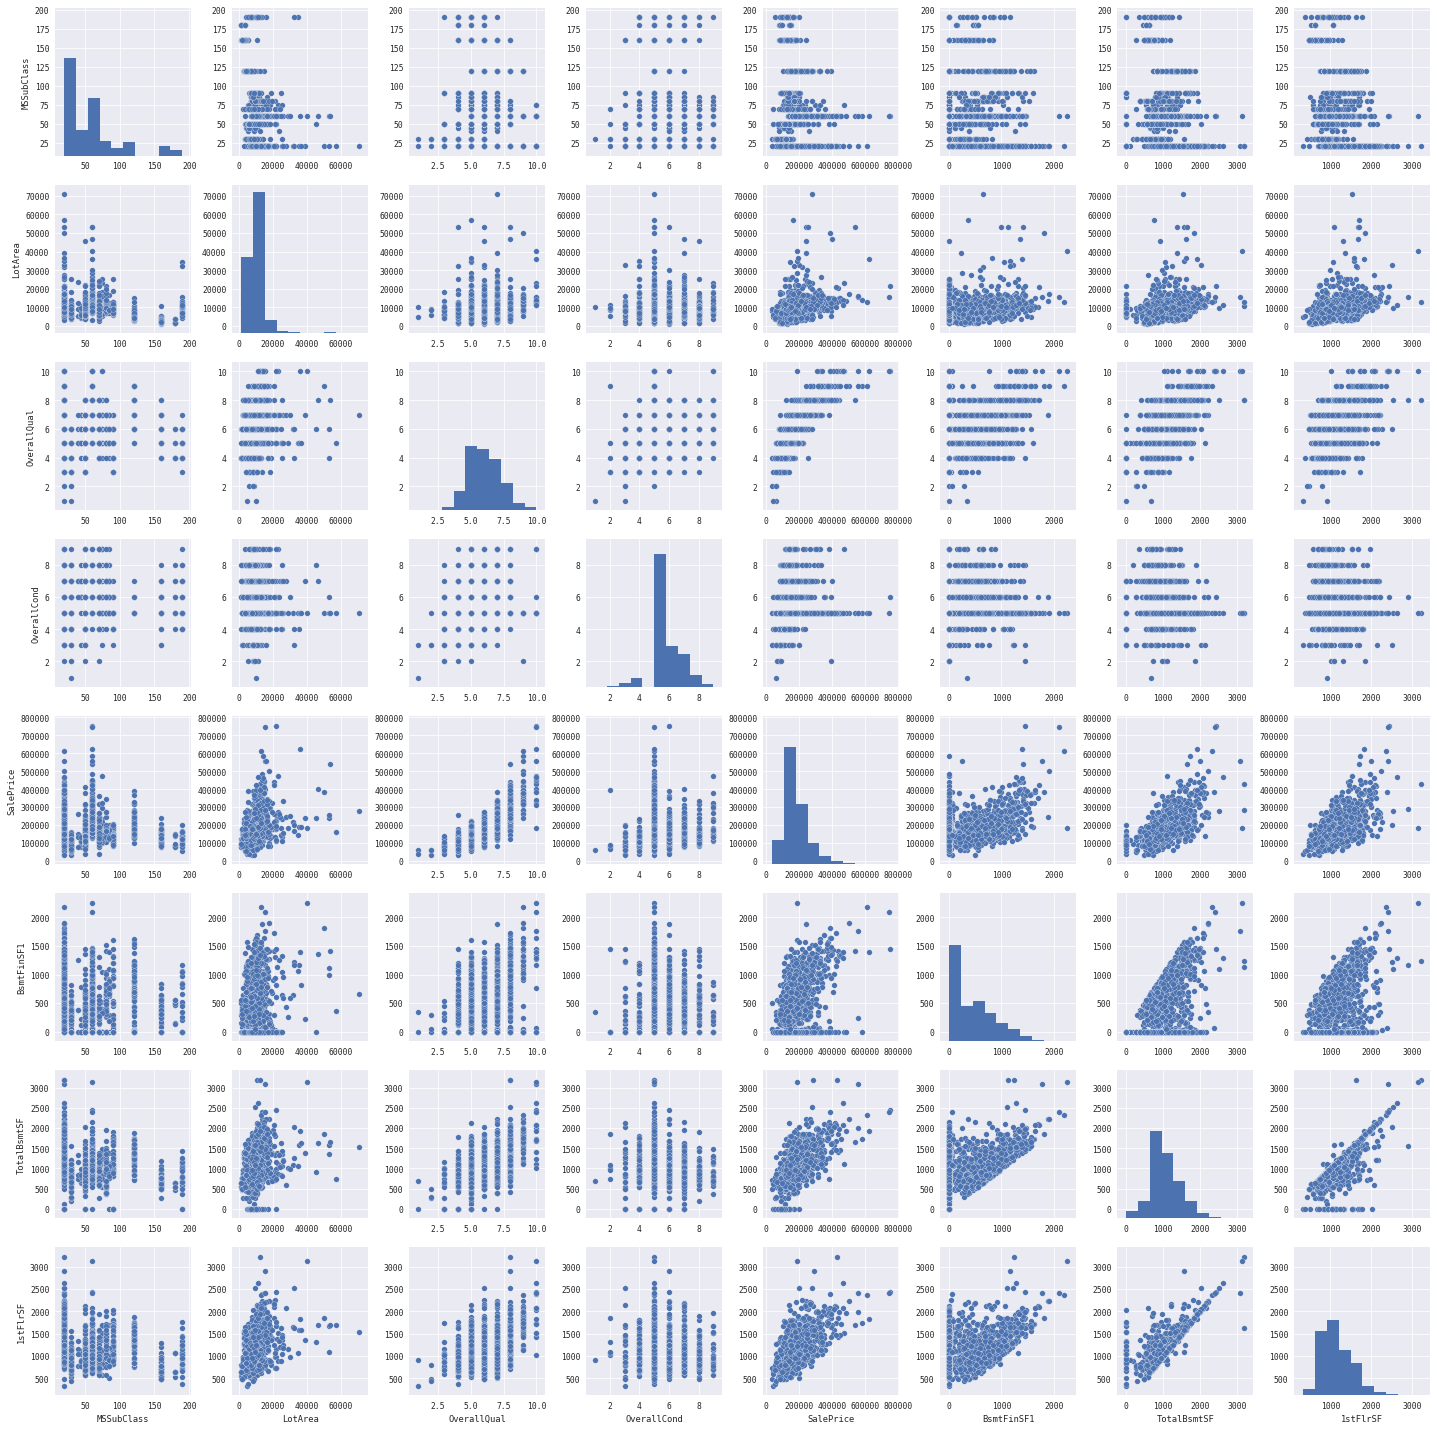

In [17]:
sb.pairplot(training_set[['MSSubClass','LotArea','OverallQual','OverallCond',\
                          'SalePrice','BsmtFinSF1','TotalBsmtSF','1stFlrSF']])

In [18]:
dummy_training = pd.get_dummies(train_x)

In [19]:
# This checks for NULL values in the dataset 
dummy_training[dummy_training.isnull().any(axis=1)]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,Gar

There are three columns with missing values. I have 3 options 
- Drop the columns
- Drop the rows
- Interpolate the NAs 

LotFrontage: highly positively correlated with garage area 
MasVnrArea: highly positively correlated with Grliving area
GarageYrBlt: highly positively correlated with year built

In light of how highly correlated the variables are with other variables, I feel alright dropping the columns. Dropping the rows would decrease the total amount of data by 339 rows, and interpolating the values isn't always accurate, and can mess up the model.

In [20]:
# filling NAs with the avg
dummy_training = dummy_training.fillna(dummy_training.mean())

In [21]:
#dummy_training.drop(['LotFrontage','MasVnrArea','GarageYrBlt'],axis=1,inplace=True)

In [22]:
dummy_training[dummy_training.isnull().any(axis=1)]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,Gar

In [383]:
# Trying K-means to come up with classes first? 
from sklearn.cluster import KMeans

In [386]:
km = KMeans(random_state=42,n_clusters=5)

fit = km.fit(dummy_training.drop(['Id'],axis=1))



In [389]:
dummy_training['clster'] = fit.labels_

In [390]:
dummy_training.clster.value_counts()

0    862
4    389
3    187
2     18
1      4
Name: clster, dtype: int64

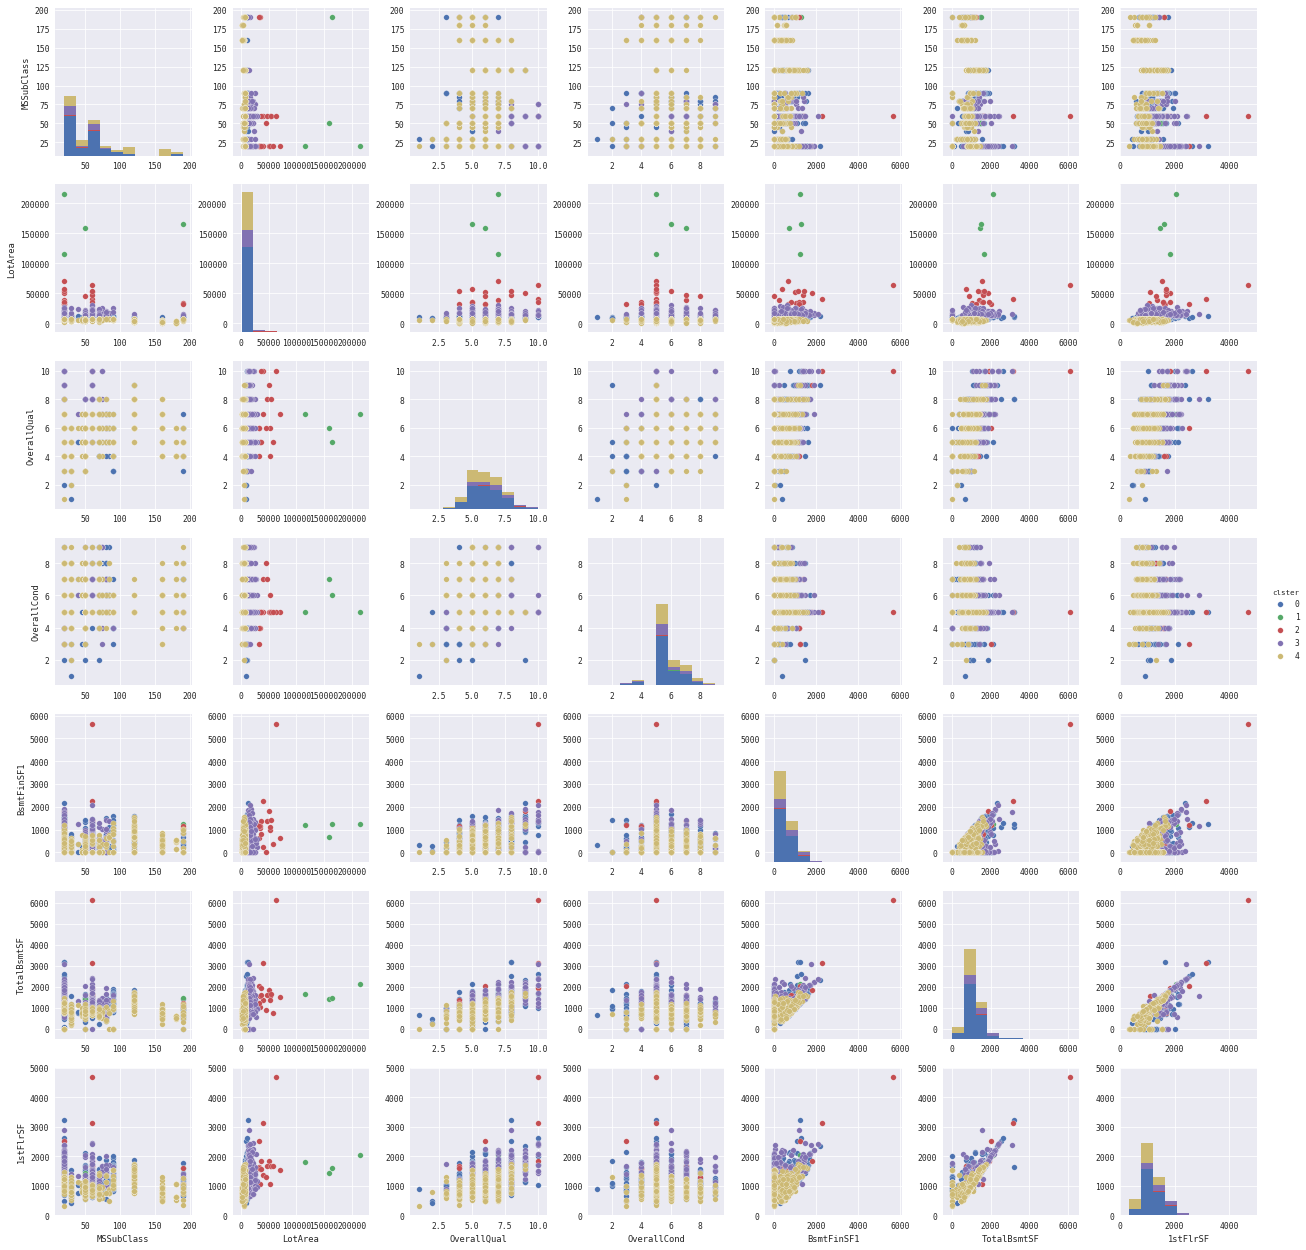

In [415]:
sb.pairplot(dummy_training,vars=['MSSubClass','LotArea','OverallQual','OverallCond',\
                          'BsmtFinSF1','TotalBsmtSF','1stFlrSF'],hue="clster")

Because the data set has so many features, I want to try some feature selection techniques to reduce the dimensionality a bit, and therefore reduce overfitting in the final model.

# Principal Component Analysis

In [23]:
pca = PCA()
dummy_fit = pca.fit(dummy_training.drop(['Id'],axis=1))

In [395]:
def horn_parallel_analysis(shape, iters=1000, percentile=95):
    pca = PCA(n_components=shape[1])
    eigenvals = []
    for i in range(iters):
        rdata = np.random.normal(0,1,size=shape)
        pca.fit(rdata)
        eigenvals.append(pca.explained_variance_)
    eigenvals = np.array(eigenvals)
    return np.percentile(eigenvals, percentile, axis=0)

In [24]:
hpa = horn_parallel_analysis(dummy_training.drop(['Id'],axis=1).shape, percentile=95)

NameError: name 'horn_parallel_analysis' is not defined

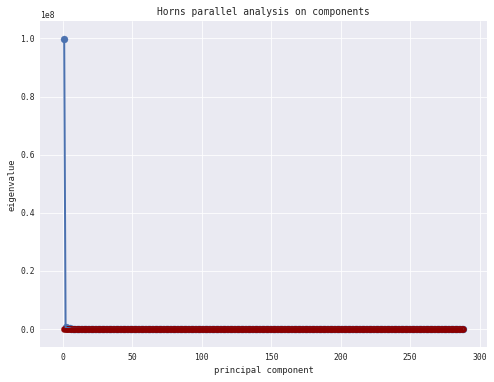

In [192]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(range(1, dummy_training.drop(['Id'],axis=1).shape[1]+1), dummy_fit.explained_variance_, lw=2)
ax.scatter(range(1, dummy_training.drop(['Id'],axis=1).shape[1]+1), dummy_fit.explained_variance_, s=50)

ax.plot(range(1, len(hpa)+1), hpa, lw=2, color='darkred')
ax.scatter(range(1, len(hpa)+1), hpa, s=40, color='darkred')


ax.set_title('Horns parallel analysis on components')
ax.set_xlabel('principal component')
ax.set_ylabel('eigenvalue')
plt.show()

In [25]:
housing_pcs = pca.transform(dummy_training.drop(['Id'],axis=1))
housing_pcs

array([[ -2.06554214e+03,   1.84498861e+01,  -2.85141930e+02, ...,
         -2.22044605e-16,   2.09901541e-16,   1.19262239e-16],
       [ -9.12040769e+02,  -1.03857284e+01,   7.43661848e+02, ...,
          5.68989300e-16,  -2.52402266e-16,   1.00830802e-16],
       [  7.34161361e+02,   8.68226313e+01,  -4.72285440e+02, ...,
         -1.80411242e-16,   7.30318583e-16,   3.82940207e-16],
       ..., 
       [ -1.45810467e+03,   6.44004831e+02,  -1.00849719e+03, ...,
          8.10115863e-16,  -2.76688394e-16,   1.09070739e-16],
       [ -8.09875892e+02,  -6.33739137e+02,   3.04310550e+02, ...,
          3.19189120e-16,   1.43027951e-15,   1.30082577e-15],
       [ -5.76014678e+02,  -1.13953145e+02,   7.02563011e+02, ...,
         -1.56125113e-16,   5.12610787e-16,  -7.56773116e-17]])

In [26]:
pca_dataframe = pd.DataFrame(housing_pcs, columns=['PC'+str(i) for i in range(1, housing_pcs.shape[1]+1)])

columns_ = pca_dataframe.columns.tolist()
exclude_cols = pca_dataframe.columns[10:]

predictors_PC = pca_dataframe[[i for i in columns_ if i not in exclude_cols]]
predictors_PC = predictors_PC.values

In [27]:

X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA= train_test_split(predictors_PC, train_y, train_size=.75, random_state=1)

# Show the results of the split
print ("Training set has {} samples.".format(X_train_PCA.shape[0]))
print ("Testing set has {} samples.".format(X_test_PCA.shape[0]))

Training set has 1095 samples.
Testing set has 365 samples.


In [399]:
gradient_booster =  GradientBoostingRegressor(random_state=42)

params = [{'max_depth':[2,3,4,5,6,7,8,9]},{'n_estimators':[10,25,50,75,100,125,150,200]},
          {'learning_rate':[.001,.01,.095,.1,.105,.15,.2,.25,.3,.4]},{'max_depth':[2,3,4,5,6]},
          {'min_samples_split':[2,4,5,6,7,8]}]

GB_gs_pc = GridSearchCV(gradient_booster, params, cv=5, verbose=1)
GB_gs_pc.fit(X_train_PCA, y_train_PCA)

print (GB_gs_pc.best_params_)
best_GB_pc = GB_gs_pc.best_estimator_

Fitting 5 folds for each of 37 candidates, totalling 185 fits


[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:   25.2s finished


{'n_estimators': 75}


In [400]:
best_GB_pc

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=75, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [401]:
preds = best_GB_pc.predict(X_test_PCA)

In [402]:
#pca_msqe = mean_squared_error(y_test_PCA,preds) # yikes
pca_mean = mean_squared_error(y_test_PCA,preds)
#print (pca_msqe)
#print (pca_median) # 15 components
#print (pca_stddev) # 10 components
print (pca_mean)

# With dropped outliers 
#  2058159231.82 10 components 

# with Kmeans clustering 

1815027974.38


In [28]:
parameters = {'max_leaf':[100,200,300,400],
 'algorithm':("RGF_Sib","RGF"),
 'l2':[0.1,0.2],
 'min_samples_leaf':[5,10],
 'learning_rate': [.05,.1,]}

rgf = RGFRegressor()
clf = GridSearchCV(estimator=rgf,
                   param_grid=parameters,
                   scoring='neg_mean_squared_error',
                   n_jobs = -1,
                   cv = 3)

estimator =  clf.fit(X_train_PCA, y_train_PCA)

best_clf = estimator.best_estimator_

preds = best_clf.predict(X_test_PCA)

print (mean_squared_error(y_test_PCA,preds))

# 1724823061.42

1724823061.42


# PCA with Standard Scaler

In [29]:
ss = StandardScaler()

In [30]:
scaled_df = ss.fit_transform(dummy_training.drop(['Id'],axis=1))

In [31]:
pca_scaled = pca.fit(scaled_df)


In [406]:
hpa = horn_parallel_analysis(scaled_df.shape, percentile=95)

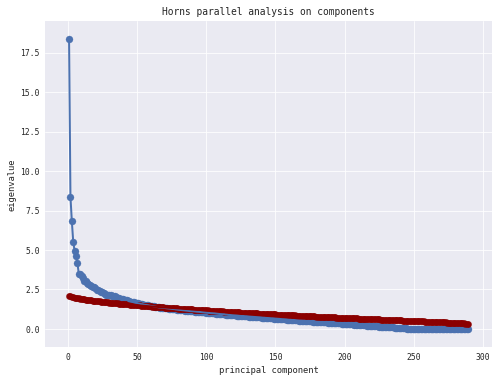

In [407]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(range(1, scaled_df.shape[1]+1), pca_scaled.explained_variance_, lw=2)
ax.scatter(range(1, scaled_df.shape[1]+1), pca_scaled.explained_variance_, s=50)

ax.plot(range(1, len(hpa)+1), hpa, lw=2, color='darkred')
ax.scatter(range(1, len(hpa)+1), hpa, s=40, color='darkred')


ax.set_title('Horns parallel analysis on components')
ax.set_xlabel('principal component')
ax.set_ylabel('eigenvalue')
plt.show()

In [33]:
pcs_scaled =pca.transform(scaled_df)

In [37]:
pca_dataframe = pd.DataFrame(pcs_scaled, columns=['PC'+str(i) for i in range(1, pcs_scaled.shape[1]+1)])

columns_ = pca_dataframe.columns.tolist()
exclude_cols = pca_dataframe.columns[20:]

predictors_PC = pca_dataframe[[i for i in columns_ if i not in exclude_cols]]
predictors_PC = predictors_PC.values

In [38]:

X_train_PCA_SS, X_test_PCA_SS, y_train_PCA_SS, y_test_PCA_SS= train_test_split(predictors_PC, train_y, train_size=.75, random_state=1)

# Show the results of the split
print ("Training set has {} samples.".format(X_train_PCA.shape[0]))
print ("Testing set has {} samples.".format(X_test_PCA.shape[0]))

Training set has 1095 samples.
Testing set has 365 samples.


In [442]:
gradient_booster =  GradientBoostingRegressor(random_state=42)

params = [{'loss':['ls','lad','huber','quantile']},{'max_depth':[2,3,4,5,6,7,8,9]},{'n_estimators':[10,25,50,75,100,125,150,200]},
          {'learning_rate':[.001,.01,.095,.1,.105,.15,.2,.25,.3,.4]},{'max_depth':[2,3,4,5,6]},
          {'min_samples_split':[2,4,5,6,7,8]}, {'min_samples_leaf':[1,2,4,8,10,12]}]

GB_gs_pc_ss = GridSearchCV(gradient_booster, params, cv=5, verbose=1)
GB_gs_pc_ss.fit(X_train_PCA_SS, y_train_PCA_SS)

print (GB_gs_pc_ss.best_params_)
best_GB_pc_ss_v = GB_gs_pc_ss.best_estimator_

Fitting 5 folds for each of 47 candidates, totalling 235 fits


[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed:   52.8s finished


{'learning_rate': 0.2}


In [443]:
best_GB_pc_ss_v

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [444]:
preds_ss = best_GB_pc_ss_v.predict(X_test_PCA_SS)

In [445]:
#ss_msqe = mean_squared_error(y_test_PCA,preds_ss) 
ss_msqe_mean = mean_squared_error(y_test_PCA_SS,preds_ss) # better 

print(ss_msqe_mean) 
# 10 components = 630,701,152.923
# 25 components = 850,160,727.41
# 40 components = 780,200,169.799
# 30 components = 733,623,076.517
# 27 components = 694,785,291.91
# 20 components = 836,077,700.501
# 24 components = 784,156,493.769

# with dropped outliers 
# 27 components =  1,257,577,133.31
# 40 components = 1,227,156,527.71

# with clusters 
# 40 components =937157801.455
# 25 909949267.376
# 15  780155830.775

780155830.775


In [39]:
parameters = {'max_leaf':[100,200,300,400],
 'algorithm':("RGF_Sib","RGF"),
 'l2':[0.1,0.2],
 'min_samples_leaf':[5,10],
 'learning_rate': [.05,.1,]}

rgf = RGFRegressor()
clf = GridSearchCV(estimator=rgf,
                   param_grid=parameters,
                   scoring='neg_mean_squared_error',
                   n_jobs = -1,
                   cv = 3)

estimator =  clf.fit(X_train_PCA_SS, y_train_PCA_SS)

best_clf = estimator.best_estimator_

preds = best_clf.predict(X_test_PCA_SS)

print (mean_squared_error(y_test_PCA_SS,preds))

# 1724823061.42 with PCA alone
# 874104937.357 w PCA and SS 15 components
# 1000608985.83 w PCA and SS 20 components

1000608985.83


# SVD

Variance preserved by first 25 components == 100.00%


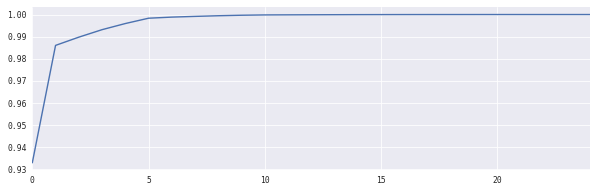

In [40]:
ncomps = 25
svd = TruncatedSVD(n_components=ncomps,random_state=42,n_iter=5)
svd_fit = svd.fit(dummy_training.drop(['Id'],axis=1))
Y = svd.fit_transform(dummy_training.drop(['Id'],axis=1))
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10,3))
print('Variance preserved by first {0} components == {1:.2%}'.format(ncomps,
        svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [41]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)],\
                     index=dummy_training.drop(['Id'],axis=1).index)
print(dfsvd.shape)
dfsvd.head()

(1460, 25)


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24
0,9314.036412,-2448.879981,-21.464869,-285.798242,737.069682,-176.224686,-189.556048,-59.201861,47.609528,15.279846,-109.886900,11.908877,-9.970040,-16.220963,-27.314701,-20.149805,1.962204,-5.927330,-4.637292,-17.471942,7.655849,2.984463,-4.273967,0.399605,0.414633
1,10427.887233,-2146.555434,-0.881896,744.473899,230.164619,-52.345292,-78.321988,58.700045,-48.788476,-98.380851,203.975623,-25.226032,-26.147442,2.456346,-0.049260,-32.593616,-1.556874,-4.341241,7.761830,0.482085,-6.367671,-2.086257,-1.252537,0.060403,-2.481164
2,12049.057215,-1850.618648,20.771073,-474.397485,410.649856,-130.719938,-177.890729,-79.586721,63.276094,-35.667626,-111.269323,-5.222930,-28.434125,-16.301193,-27.570788,-14.579153,2.395178,-6.296698,-4.055259,-14.626310,6.489987,1.568133,2.708712,-1.166447,0.295312
3,10367.903171,-2147.866377,-111.570372,-576.662192,183.153274,-100.825739,8.515789,-109.848466,17.572067,-181.812344,-113.782688,-178.636141,144.078544,-3.240817,80.494813,16.930463,-21.563775,2.207227,-12.618428,-3.304764,-11.693088,38.873467,-3.956782,-0.663691,-0.253625
4,15049.986027,-1412.753180,522.255732,-565.706245,514.951004,-127.198491,-186.840275,-241.401610,142.266473,4.163907,31.090374,0.418897,3.805862,-7.268112,-16.710513,-17.384478,-2.632407,-4.521827,2.528783,0.050549,0.060094,-1.084553,5.526308,0.388577,0.174228


In [42]:

X_train_SVD, X_test_SVD, y_train_SVD, y_test_SVD= train_test_split(dfsvd, train_y, train_size=.75, random_state=1)

# Show the results of the split
print ("Training set has {} samples.".format(X_train_SVD.shape[0]))
print ("Testing set has {} samples.".format(X_test_SVD.shape[0]))

Training set has 1095 samples.
Testing set has 365 samples.


In [449]:
gradient_booster =  GradientBoostingRegressor(random_state=42)

params = [{'max_depth':[2,3,4,5,6,7,8,9]},{'n_estimators':[10,25,50,75,100,125,150,200]},
          {'learning_rate':[.001,.01,.095,.1,.105,.15,.2,.25,.3,.4]},{'max_depth':[2,3,4,5,6]},
          {'min_samples_split':[2,4,5,6,7,8]}]

best_GB_pc_min_max = GridSearchCV(gradient_booster, params, cv=10, verbose=1)
best_GB_pc_min_max.fit(X_train_SVD, y_train_SVD)

print (best_GB_pc_min_max.best_params_)
best_GB_pc_min_max = best_GB_pc_min_max.best_estimator_

Fitting 10 folds for each of 37 candidates, totalling 370 fits


[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:  2.3min finished


{'max_depth': 4}


In [450]:
preds_SVD = best_GB_pc_min_max.predict(X_test_SVD)


msqe_mean_svd = mean_squared_error(y_test_SVD,preds_SVD) 

In [451]:
msqe_mean_svd
# 1711155998.6696701 10
# 1046385126.8413106 25 
# 848,627,550.39654958 30
# 881,982,883.4931947 40 w additional cross validation 
# 35  971,014,627.38427413

# dropped outliers 
# 1,465,152,357.0022106

# Clusters
# 1,165,090,507.4682291

1165090507.4682291

In [43]:
parameters = {'max_leaf':[100,200,300,400],
 'algorithm':("RGF_Sib","RGF"),
 'l2':[0.1,0.2],
 'min_samples_leaf':[5,10],
 'learning_rate': [.05,.1,]}

rgf = RGFRegressor()
clf = GridSearchCV(estimator=rgf,
                   param_grid=parameters,
                   scoring='neg_mean_squared_error',
                   n_jobs = -1,
                   cv = 3)

estimator =  clf.fit(X_train_SVD, y_train_SVD)

best_clf = estimator.best_estimator_

preds = best_clf.predict(X_test_SVD)

print (mean_squared_error(y_test_SVD,preds))

# 1724823061.42 with PCA alone
# 874104937.357 w PCA and SS 15 components
# 1000608985.83 w PCA and SS 20 components
# 1315142482.47 with SVD

1315142482.47


Variance preserved by first 200 components == 97.42%


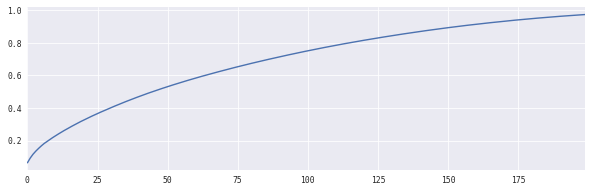

In [44]:
# svd w scaled 
scaled_df = ss.fit_transform(dummy_training.drop(['Id'],axis=1))



ncomps = 200
svd = TruncatedSVD(n_components=ncomps,random_state=42,n_iter=5)
svd_fit = svd.fit(scaled_df)
Y = svd.fit_transform(scaled_df)
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10,3))
print('Variance preserved by first {0} components == {1:.2%}'.format(ncomps,
        svd_fit.explained_variance_ratio_.cumsum()[-1]))




In [45]:
Y.shape

(1460, 200)

In [46]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)])
print(dfsvd.shape)
dfsvd.head()



(1460, 200)


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39,c40,c41,c42,c43,c44,c45,c46,c47,c48,c49,c50,c51,c52,c53,c54,c55,c56,c57,c58,c59,c60,c61,c62,c63,c64,c65,c66,c67,c68,c69,c70,c71,c72,c73,c74,c75,c76,c77,c78,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99,c100,c101,c102,c103,c104,c105,c106,c107,c108,c109,c110,c111,c112,c113,c114,c115,c116,c117,c118,c119,c120,c121,c122,c123,c124,c125,c126,c127,c128,c129,c130,c131,c132,c133,c134,c135,c136,c137,c138,c139,c140,c141,c142,c143,c144,c145,c146,c147,c148,c149,c150,c151,c152,c153,c154,c155,c156,c157,c158,c159,c160,c161,c162,c163,c164,c165,c166,c167,c168,c169,c170,c171,c172,c173,c174,c175,c176,c177,c178,c179,c180,c181,c182,c183,c184,c185,c186,c187,c188,c189,c190,c191,c192,c193,c194,c195,c196,c197,c198,c199
0,4.273564,1.573861,-2.347276,1.889500,0.878837,-1.212415,0.883619,-1.522989,0.212166,-0.256475,-0.826268,0.560979,-0.577503,0.169717,0.672503,0.461882,-0.589273,1.273221,0.939511,1.366383,0.467781,0.179181,-0.775176,0.832869,-0.049635,-0.135985,0.959015,0.127614,0.492483,-0.122149,0.010146,-0.502286,-0.969962,1.305920,-0.077909,0.788884,0.439446,-0.368490,-0.793200,-0.243375,0.508353,0.034714,-0.250338,0.525418,-0.133625,-0.292566,-1.069135,0.053456,-0.172699,0.655054,0.099528,-0.171017,-0.093380,-0.238572,0.358984,0.236436,0.251535,0.364644,-0.019134,0.547756,-0.019050,-0.165901,-0.406957,0.023039,-0.740576,-0.448764,-0.866656,0.249178,0.311366,0.387482,0.210466,0.424312,0.514378,-0.317242,-0.046600,0.198835,0.098233,-0.189392,0.089737,-0.489777,0.384860,0.125984,0.685508,-0.199434,-0.002446,0.715087,-0.402186,0.406992,0.194511,-0.262685,0.057910,0.087283,-0.108762,0.169926,0.488151,-0.172602,-0.568225,-0.393707,0.537087,-0.298344,-0.303028,-0.320205,0.292380,0.402472,-0.142632,0.672013,0.231499,-0.170684,-0.223649,0.129454,-0.719043,0.435691,-0.062323,-0.512066,-0.044774,0.520659,-0.530762,-0.190481,0.427100,-0.420026,0.689374,-0.321760,-0.002795,-0.517979,0.578497,-0.125875,0.397887,0.010195,-0.183648,0.083307,-0.232375,0.119626,0.165319,-0.107423,0.090022,0.219816,-0.277175,-3.473191e-07,0.524230,0.495929,-0.004948,-0.273381,-0.539986,-0.050325,-0.176384,-0.067928,0.078895,0.011270,-0.440216,0.016467,0.144354,0.151982,0.148251,0.270516,0.022654,0.101747,-0.452224,-0.149014,-0.036631,0.164830,0.213069,0.319625,-0.100418,-0.118452,-0.298107,0.582616,0.334732,0.324648,-0.283314,0.027956,-0.149589,-0.066872,0.210283,0.018443,-0.283984,0.344450,0.104447,-0.173883,0.346220,-0.153599,-0.020508,0.306415,0.048837,-0.149841,0.272034,0.035171,0.138481,0.067065,-0.093865,-0.288311,-0.017303,-0.282850,-0.301929,0.034555,0.341888,-0.156649,-0.332731,-0.019865,-0.004768,0.050240
1,-0.092288,-3.219660,-0.681620,0.100556,0.153340,-0.536780,-0.927456,-0.745352,0.088131,2.186819,-0.847602,1.055973,-0.338389,-0.658294,-0.523828,0.127561,0.173549,-0.378522,-1.596618,-0.646725,0.201713,-3.663246,0.986448,-0.053545,-1.215603,0.704588,-0.614591,-0.186385,-0.549097,2.138440,-1.269955,-0.787354,0.262027,-0.628747,0.380079,-0.941045,1.147394,-0.291994,-1.026383,-0.908957,-0.827875,0.229239,-0.968863,-2.449791,-0.296637,1.151375,3.209952,-0.643855,-0.491245,1.112830,0.351675,-1.615965,-1.077338,-1.663750,0.223375,0.239391,0.723882,-0.457326,-1.717050,-1.805552,0.248893,-4.181701,1.285404,0.026353,1.820021,1.037184,-2.499681,0.197114,3.641558,-0.379839,-0.563791,1.462439,2.049641,1.124343,-2.010177,-1.482627,1.098440,0.610572,1.292495,-1.411260,-0.005360,2.294271,2.288770,-0.580905,-0.564172,-2.230321,-1.714049,0.126018,1.368859,1.320549,1.014730,1.463940,0.042245,0.251403,0.588543,0.577681,-1.315511,1.634867,0.671579,0.080160,1.064744,-2.342497,0.906146,-0.298904,-0.342155,-1.687107,0.282883,0.188891,1.700666,-0.013296,1.160058,1.143645,-0.172851,1.966428,-0.195035,-0.689737,1.322152,-0.892830,-1.691506,-0.681558,-0.527681,-0.760026,-0.068388,-1.231242,1.206602,-0.240842,-1.1

In [47]:

X_train_SVD, X_test_SVD, y_train_SVD, y_test_SVD= train_test_split(dfsvd, train_y, train_size=.75, random_state=1)

# Show the results of the split
print ("Training set has {} samples.".format(X_train_SVD.shape[0]))
print ("Testing set has {} samples.".format(X_test_SVD.shape[0]))



Training set has 1095 samples.
Testing set has 365 samples.


In [ ]:
gradient_booster =  GradientBoostingRegressor(random_state=42)

params = [{'max_depth':[2,3,4,5,6,7,8,9]},{'n_estimators':[10,25,50,75,100,125,150,200]},
          {'learning_rate':[.001,.01,.095,.1,.105,.15,.2,.25,.3,.4]},{'max_depth':[2,3,4,5,6]},
          {'min_samples_split':[2,4,5,6,7,8]}]

best_GB_pc_min_max = GridSearchCV(gradient_booster, params, cv=10, verbose=1)
best_GB_pc_min_max.fit(X_train_SVD, y_train_SVD)

print (best_GB_pc_min_max.best_params_)
best_GB_pc_min_max = best_GB_pc_min_max.best_estimator_

Fitting 10 folds for each of 37 candidates, totalling 370 fits


In [ ]:
preds_SVD = best_GB_pc_min_max.predict(X_test_SVD)


msqe_mean_svd = mean_squared_error(y_test_SVD,preds_SVD) 



In [ ]:
msqe_mean_svd

# 967818970.96463919 200
# 765146963.87908769 100 
# 854004869.43272722 50
# 831263981.57036138 150 


# Clusters

# 774531968.33513916  125

# 200

In [48]:
parameters = {'max_leaf':[100,200,300,400],
 'algorithm':("RGF_Sib","RGF"),
 'l2':[0.1,0.2],
 'min_samples_leaf':[5,10],
 'learning_rate': [.05,.1,]}

rgf = RGFRegressor()
clf = GridSearchCV(estimator=rgf,
                   param_grid=parameters,
                   scoring='neg_mean_squared_error',
                   n_jobs = -1,
                   cv = 3)

estimator =  clf.fit(X_train_SVD, y_train_SVD)

best_clf = estimator.best_estimator_

preds = best_clf.predict(X_test_SVD)

print (mean_squared_error(y_test_SVD,preds))

# 1724823061.42 with PCA alone
# 874104937.357 w PCA and SS 15 components
# 1000608985.83 w PCA and SS 20 components
# 1315142482.47 with SVD alone
# 1132892856.96

1132892856.96


In [286]:
# Anomaly Detection

predictors = list(range(0,288))


X_train, X_test, y_train, y_test= train_test_split(dummy_training.drop(['Id'],axis=1), train_y, train_size=.75, random_state=1)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

h2o.init(nthreads=-1, enable_assertions = False)
X_train.hex=h2o.H2OFrame(X_train)
X_test.hex=h2o.H2OFrame(X_test)

model=H2OAutoEncoderEstimator(activation="Tanh",hidden=[20],ignore_const_cols=False,epochs=100)

model.train(x=predictors,training_frame=X_train.hex)

model._model_json['output']

test_rec_error=model.anomaly(X_test.hex)
test_rec_error.describe()

test_rec_error_df=test_rec_error.as_data_frame()

boxplotEdges=test_rec_error_df.quantile(.75)
iqr = np.subtract(*np.percentile(test_rec_error_df, [75, 25]))
top_whisker=boxplotEdges[0]+(1.5*iqr)
top_whisker

test_rec_error_df['id']=test_rec_error_df.index

# Scatter plot with top whisker
test_rec_error_df.plot(kind='scatter',x='id',y='Reconstruction.MSE')
plt.axhline(y=top_whisker,linewidth=2, color='r')
plt.show()

# test_rec_error_df[test_rec_error_df['Reconstruction.MSE']>=.07]


Training set has 1095 samples.
Testing set has 365 samples.


In [56]:
# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(289, input_dim=289, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)


In [57]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, dummy_training, train_y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -6370711126.10 (4016381897.49) MSE


In [65]:
def larger_model():
	# create model
	model = Sequential()
	model.add(Dense(20, input_dim=289, kernel_initializer='normal', activation='relu'))
	model.add(Dense(10, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [66]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, dummy_training, train_y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Larger: -3022459994.90 (1752740027.27) MSE


KFold(n_splits=10, random_state=7, shuffle=False)

In [301]:
test_rec_error_df=test_rec_error.as_data_frame()

In [302]:
boxplotEdges=test_rec_error_df.quantile(.75)
iqr = np.subtract(*np.percentile(test_rec_error_df, [75, 25]))
top_whisker=boxplotEdges[0]+(1.5*iqr)
top_whisker

0.053251740105974721

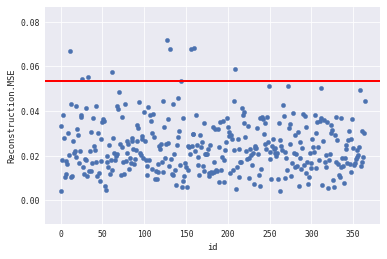

In [303]:
test_rec_error_df['id']=test_rec_error_df.index

# Scatter plot with top whisker
test_rec_error_df.plot(kind='scatter',x='id',y='Reconstruction.MSE')
plt.axhline(y=top_whisker,linewidth=2, color='r')
plt.show()




In [307]:
test_rec_error_df[test_rec_error_df['Reconstruction.MSE']>=.07]

,Reconstruction.MSE,id
127,0.072017,127


In [147]:
dummy_Test = pd.get_dummies(test)
dummy_Test.fillna(dummy_training.mean(),inplace=True)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.000000,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.000000,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.000000,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.000000,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.000000,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0
5,1466,60,75.000000,10000,6,5,1993,1994,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
6,1467,20,70.049958,7980,6,7,1992,2007,0.0,935.0,...,0,0,0,1,0,0,0,0,1,0
7,1468,60,63.000000,8402,6,5,1998,1998,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
8,1469,20,85.000000,10176,7,5,1990,1990,0.0,637.0,...,0,0,0,1,0,0,0,0,1,0
9,1470,20,70.000000,8400,4,5,1970,1970,0.0,804.0,...,0,0,0,1,0,0,0,0,1,0


In [148]:
dummy_Test[dummy_Test.isnull().any(axis=1)]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial


In [149]:
scaled_df = ss.fit_transform(dummy_Test)
dummy_fit_test = pca.fit_transform(scaled_df)

In [150]:
TEST_pca_dataframe = pd.DataFrame(dummy_fit_test, columns=['PC'+str(i) for i in range(1, dummy_fit_test.shape[1]+1)])

columns_ = TEST_pca_dataframe.columns.tolist()
exclude_cols = TEST_pca_dataframe.columns[27:]

predictors_PC = TEST_pca_dataframe[[i for i in columns_ if i not in exclude_cols]]
predictors_PC = predictors_PC.values

In [151]:
test_preds = best_GB_pc_ss_v.predict(predictors_PC)

In [152]:
dummy_Test['SalePrice'] = test_preds

In [153]:
min(dummy_Test.SalePrice)

86974.542932029086

In [154]:
dummy_Test[['Id','SalePrice']].to_csv('~/Desktop/PCA_StandardScaler_Predictions_v7_PCA_SS.csv',index=None)